# Historical Implementation - Eigen Network (2014)

#### The basic code was taken from - https://github.com/shuuchen/depth_eigen/blob/master/depth_eigen.ipynb

### Original work has not released a github code

In [1]:
!pip -q install tqdm
from tqdm.auto import tqdm
!pip install torchsummary

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Mount Google Drive

In [3]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# replace with your own preferred path
DRIVE_PATH = '/content/drive/MyDrive/kitti/kitti-eigen-split-dataset'

# create the directory if it doesn't exist
import os
os.makedirs(DRIVE_PATH, exist_ok=True)

# set root folder for the dataset loader
DATA_ROOT = DRIVE_PATH

## Download the Kitti Eigen Split dataset from Kaggle

#### Link to Kaggle dataset for Eigen split - https://www.kaggle.com/datasets/awsaf49/kitti-eigen-split-dataset

In [ ]:
# install kaggle cli
!pip install kaggle --quiet

In [ ]:
# environment variables directly
from google.colab import userdata

In [ ]:
!pip -q install kaggle

import getpass, os
os.environ['KAGGLE_USERNAME'] = userdata.get('kaggle_user_name') # set kaggle user name
os.environ['KAGGLE_KEY'] = userdata.get('kaggle_key') # set Kaggle key

### Download and unzip the dataset

In [ ]:
# download + unzip
!kaggle datasets download -d awsaf49/kitti-eigen-split-dataset -p "$DRIVE_PATH" --unzip

# verify contents
!ls -lah "$DRIVE_PATH"

Dataset URL: https://www.kaggle.com/datasets/awsaf49/kitti-eigen-split-dataset
License(s): CC0-1.0
User cancelled operation
total 8.0K
drwx------ 2 root root 4.0K Oct 20 06:48 test
drwx------ 2 root root 4.0K Oct 20 06:49 train


## Load and format the dataset

In [5]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Output resolution expected by the model (width=576, height=172)
KITTI_W, KITTI_H = 576, 172


class KittiEigenSplitDataset(Dataset):
    """
    Dataset loader from KITTI Eigen Split.
    This loader pairs each RGB frame with its corresponding depth map,
    handling both groundtruth and Velodyne-projected (lidar sensor projected) depths
    """

    def __init__(self, root_dir, split='train', transform=None, max_pairs=None, camera='image_02'):
        self.root = Path(root_dir)
        self.split = split
        self.transform = transform
        self.camera = camera
        self.pairs = []   # store tuples: (rgb_path, depth_path, use_velodyne)

        # Construct full path of the split (Each split has its own valid folder - train / validation / split)
        split_root = self.root / split
        if not split_root.exists():
            raise FileNotFoundError(f"Split folder not found: {split_root}")

        # Kitti dataset is organized by date folders each containing sevaral drive folders
        for date_dir in sorted([p for p in split_root.iterdir() if p.is_dir()]):
            for drive_dir in sorted([p for p in date_dir.iterdir() if p.is_dir() and p.name.endswith('_sync')]):

                # Standard KITTI locations for RGB frames and groundtruth depth
                rgb_dir = drive_dir / self.camera / "data"
                gt_dir  = drive_dir / "proj_depth" / "groundtruth" / self.camera

                # Folders without RGB frames are skipped
                if not rgb_dir.exists():
                    continue

                rgb_files = sorted(rgb_dir.glob("*.png"))
                if not rgb_files:
                    continue

                # Some sequences do not include groundtruth depth.
                # In such cases fall back to Velodyne-projected depth maps.
                use_velodyne = False
                if not gt_dir.exists() or len(list(gt_dir.glob("*.png"))) == 0:
                    gt_raw = drive_dir / "proj_depth" / "velodyne_raw" / self.camera
                    if gt_raw.exists() and len(list(gt_raw.glob("*.png"))) > 0:
                        gt_dir = gt_raw
                        use_velodyne = True
                    else:
                        continue

                # Match filenames
                for rgb_path in rgb_files:
                    fname = rgb_path.name
                    depth_path = gt_dir / fname

                    # Only store pairs where the depth map exists
                    if depth_path.exists():
                        self.pairs.append((rgb_path, depth_path, use_velodyne))

                    # Allows limiting the number of samples
                    if max_pairs is not None and len(self.pairs) >= max_pairs:
                        break

                if max_pairs is not None and len(self.pairs) >= max_pairs:
                    break

            if max_pairs is not None and len(self.pairs) >= max_pairs:
                break

        if len(self.pairs) == 0:
            raise RuntimeError(f"No RGB/Depth pairs found in {split_root} using {self.camera}")

        # ImageNet Normalization is applied to images.
        # (Normalizing the input to the same mean and standard deviation helps the feature extractor behave consistently)
        self.norm = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        rgb_path, depth_path, _ = self.pairs[idx]

        # RGB images are loaded using PIL and converted to standard 3 channel format
        rgb = Image.open(rgb_path).convert("RGB")

        # The image is resized to the model's expected input size. (To keep image dimensions consistent across all dimensions)
        rgb = rgb.resize((KITTI_W, KITTI_H), Image.BILINEAR)

        # Convert RGB to tensor and normalize it using image net normalization
        rgb_t = self.to_tensor(rgb)
        rgb_t = self.norm(rgb_t)

        # Load depth (Kitti depth maps are stored as 16-bit PNGs)
        # Loading them as unit 16 preserves the full depth range
        depth_raw = np.array(Image.open(depth_path), dtype=np.uint16)

        # Convert to meters BEFORE resize (KITTI encodes depth values in 1/256 meters.)
        # Converting to float and deviding restores true metric depth.
        depth_np = depth_raw.astype(np.float32) / 256.0

        # Depth is resized after converting to meters.
        # Nearest-neighbour interpolation is used to avoid introducing artificial depth values between sparse LiDAR points
        depth_np = cv2.resize(depth_np, (KITTI_W, KITTI_H), interpolation=cv2.INTER_NEAREST)

        # Depth is converted in to a shape [1, H, W]
        depth_t = torch.from_numpy(depth_np).unsqueeze(0)

        # Mask invalid depth (zeros) (Depth value zero are missing LiDar returns)
        # Setting them to zero makes it easier to mask them during training
        depth_t[depth_t <= 0] = 0.0

        return rgb_t, depth_t

# Historical Implementation - Eigen Network (2014) (First Deep Learning Approach)

## Paper : Depth Map Prediction from a Single Image using a Multi-Scale Deep Network

## Authors: David Eigen, Christian Puhrsch, Rob Fergus

### Doi : https://doi.org/10.48550/arXiv.1406.2283

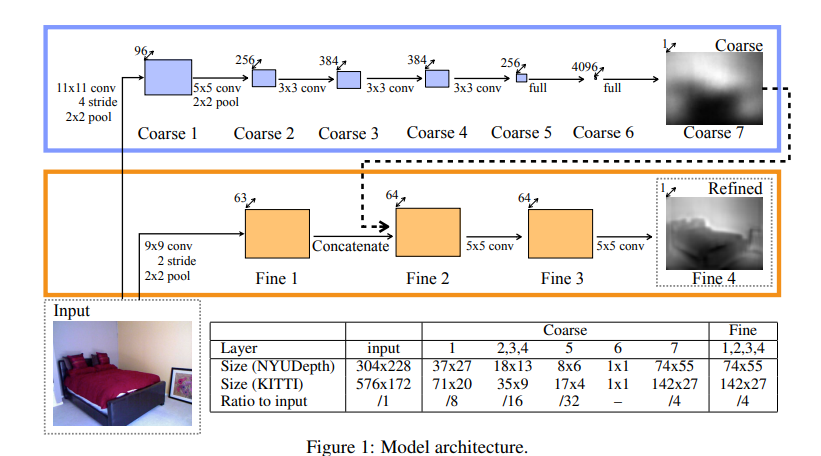

### This model uses the Eigen Coarse-to-Fine architecture, which includes:

1. **A global coarse network** for capturing the overall depth structure of the scene.
2. **A local fine network** that refines the coarse prediction using higher-resolution image details.
3. **A two-stage training process** where coarse depth is learned first, then fine and coarse are trained together.

**Key idea:**

Depth is estimated in two steps: a stable global prediction first, followed by local refinement for sharper edges and finer details.

# Global Coarse Network Architecture

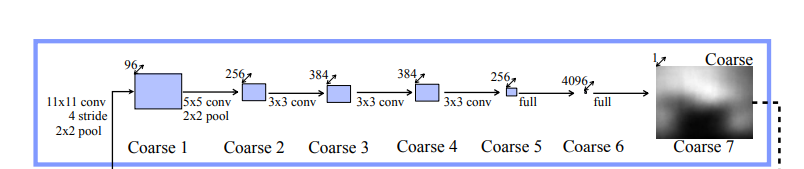

* **Convolution Layer 1:** input channels = 3, output channels = 96, kernel size = 11×11, stride = 4, followed by Max Pooling (2×2).
* **Convolution Layer 2:** input channels = 96, output channels = 256, kernel size = 5×5, stride = 1, followed by Max Pooling (2×2).
* **Convolution Layer 3:** input channels = 256, output channels = 384, kernel size = 3×3.
* **Convolution Layer 4:** input channels = 384, output channels = 384, kernel size = 3×3.
* **Convolution Layer 5:** input channels = 384, output channels = 256, kernel size = 3×3, followed by Max Pooling (2×2).
* **Adaptive Average Pooling Layer:** output size fixed to 4×17.
* **Fully Connected Layer 1:** input size = 256×4×17, output size = 4096 units with Dropout.
* **Fully Connected Layer 2:** input size = 4096, output size = 27×142 (coarse depth map).

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# input resolution = 576×172 (Width × Height)
# coarse output feature map size ≈ 142×27 = 1/4 of input

COARSE_OUT_W, COARSE_OUT_H = 142, 27


# Global (coarse) network — learns overall scene structure and provides a middle representation
class GlobalCoarseNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Coarse conv stack (paper: 11x11 s4, pool; 5x5; pool; 3x3; 3x3; 3x3; pool)

        # Conv1: input channels=3 (RGB), output=96 filters
        # Large kernel (11x11) with stride=4 quickly reduces spatial size
        self.conv1 = nn.Conv2d(3,   96, kernel_size=11, stride=4, padding=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv2: input channels=96, output=256 filters
        # Uses 5x5 kernel with padding=2 to preserve spatial shap
        self.conv2 = nn.Conv2d(96,  256, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv3–Conv5: deeper feature extraction
        # 256→384→384→256 filters progressively expand and compress features
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Adaptive pooling → fixes feature map to [256, 4, 17]
        # Ensures constant size regardless of input dimensions
        self.adapt = nn.AdaptiveAvgPool2d((4, 17))  # (H=4, W=17)

        # Fully connected (dense) layers for depth regression
        # Input: 256 feature maps * 4 * 17 spatial = 17408 features
        self.fc1 = nn.Linear(256 * 4 * 17, 4096)         # compress global context
        self.drop = nn.Dropout(p=0.5)                    # dropout regularization
        self.fc2 = nn.Linear(4096, COARSE_OUT_H * COARSE_OUT_W) # outputs flattened 27×142 map (1/4 of input size)

    def forward(self, x):
        # forward pass through conv + pool layers

        # x: [batch_size, 3, height, width]
        x = F.relu(self.conv1(x))      # [batch_size, 96, H/4, W/4]
        x = self.pool1(x)              # [batch_size, 96, H/8, W/8]

        x = F.relu(self.conv2(x))      # [batch_size, 256, H/8, W/8]
        x = self.pool2(x)              # [batch_size, 256, H/16, W/16]

        x = F.relu(self.conv3(x))      # [batch_size, 384, H/16, W/16]
        x = F.relu(self.conv4(x))      # [batch_size, 384, H/16, W/16]
        x = F.relu(self.conv5(x))      # [batch_size, 256, H/16, W/16]
        x = self.pool5(x)              # [batch_size, 256, H/32, W/32]

        x = self.adapt(x)              # [batch_size, 256, 4, 17]
        x = x.flatten(1)               # [batch_size, 256*4*17]
        x = F.relu(self.fc1(x))        # [batch_size, 4096]
        x = self.drop(x)               # [batch_size, 27*142]
        x = self.fc2(x)
        x = x.view(-1, 1, COARSE_OUT_H, COARSE_OUT_W)  # [batch_size, 1, 27, 142]
        return x

# Local Fine Network Architecture

* **Convolution Layer 1:** input channels = 3, output channels = 63, kernel size = 9×9, stride = 2, followed by Max Pooling (2×2).
* **Concatenation Step:** coarse depth (1 channel) is upsampled and concatenated with the 63-channel feature map → total input channels = 64.
* **Convolution Layer 2:** input channels = 64, output channels = 64, kernel size = 5×5, stride = 1.
* **Convolution Layer 3:** input channels = 64, output channels = 64, kernel size = 5×5, stride = 1.
* **Convolution Layer 4:** input channels = 64, output channels = 1, kernel size = 5×5, stride = 1 (refined depth output).

In [7]:
class LocalFineNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Local (fine) network — refines coarse prediction with fine image details

        # Conv1: input=3 (RGB), output=63 filters
        # Large 9x9 kernel with stride=2 reduces spatial size and captures local texture cues
        self.conv1 = nn.Conv2d(3, 63, kernel_size=9, stride=2, padding=4)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        # After pooling, coarse depth (1 channel) is concatenated → total 64 channels
        # Conv2: input=64, output=64 filters, 5x5 kernel for joint RGB-depth refinement
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)

        # Conv3: input=64, output=64 filters, another 5x5 conv for deeper local refinement
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)

        # Conv4: input=64, output=1 filter, 5x5 kernel → final refined depth map
        self.conv4 = nn.Conv2d(64, 1,  kernel_size=5, stride=1, padding=2)

    def forward(self, image, coarse):
        # image:  [batch_size, 3, height, width]   [batch_size, 3, 172, 576]
        # coarse: [batch_size, 1, 27, 142]         from global coarse network


        B, C, H, W = image.shape # [Batch size, Channels, Height, Width] [batch size, channels, 172, 576]

        # Upsample coarse prediction to full image resolution
        coarse_up_full = F.interpolate(coarse, size=(H, W), mode='bilinear', align_corners=False)

        # Extract local image features
        x = F.relu(self.conv1(image))   # [batch_size, 63, H/2, W/2]
        x = self.pool1(x)               # [batch_size, 63, H/4, W/4]

        # Resize coarse to match feature map and concatenate with RGB features
        coarse_feat = F.interpolate(coarse_up_full, size=(x.shape[2], x.shape[3]),
                                    mode='bilinear', align_corners=False)  # [batch_size, 1, H/4, W/4]

        x = torch.cat([x, coarse_feat], dim=1)   # [batch_size, 64, H/4, W/4]

        # Local refinement through deeper 5x5 conv layers
        x = F.relu(self.conv2(x))       # [batch_size, 64, H/4, W/4]
        x = F.relu(self.conv3(x))       # [batch_size, 64, H/4, W/4]
        x = self.conv4(x)               # [batch_size, 1,  H/4, W/4]

         # Output: refined depth map at 1/4 input resolution
        return x

# Full Eigen Depth Model

In [8]:
class EigenDepthModel(nn.Module):
    def __init__(self):
        super().__init__()
        # combines global (coarse) and local (fine) networks
        self.global_net = GlobalCoarseNet()
        self.local_net  = LocalFineNet()

    def forward(self, x):
         # x: [batch_size, 3, height, width]
        coarse = self.global_net(x)                   # [batch_size, 1, 27, 142]
        fine   = self.local_net(x, coarse)            # [batch_size, 1, H/4, W/4]
        return coarse, fine                           # returns both outputs

# Loss Function (Scale Invariant Logarithmic Loss)

$$
\mathcal{L}_{\text{SILog}} =
\frac{1}{N} \sum_{i=1}^{N} d_i^2
- \lambda \left( \frac{1}{N} \sum_{i=1}^{N} d_i \right)^2,
\quad
d_i = \log(\hat{y}_i + \epsilon) - \log(y_i + \epsilon)
$$

**Where:**
- $\hat{y}_i$: predicted depth  
- $y_i$: ground-truth depth  
- $N$: number of pixels  
- $\lambda$: balancing constant (paper used value - 0.5)  
- $\epsilon$: small constant to prevent $\log(0)$  

This loss computes depth error in **log-space**, making it *invariant to global scale*.  
The first term penalizes per-pixel variance, while the second corrects overall scale bias.

In [9]:
def silog_loss_masked(pred, target, mask=None, lam=0.5, eps=1e-6):
    """
    Computes the Scale-Invariant Logarithmic (SILog) loss for depth estimation

    pred, target: [batch_size, 1, height, width]  depth maps (in meters)
    mask:         [batch_size, 1, height, width]  valid pixel mask (True where target > 0)
    lam:          balancing factor for the scale correction term (paper has used it as 0.5)
    eps:          small value to prevent log(0)
    """

    # ensure inputs have channel dimension (depth maps are there with shape [batch_size, height, width])
    if pred.ndim == 3:   pred = pred.unsqueeze(1)
    if target.ndim == 3: target = target.unsqueeze(1)

    # If no mask provided, use valid pixels where target > 0 (This is done due to kitti consist with sparse depth maps)
    if mask is None:
        mask = (target > 0)

    # same dimentionalty adjust for mask
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)

    # Clamp to avoid log(0) - This is done due to logarithmic loss requires positive values
    # Values are clamped to avoid log(0) or negative depths. (adds the delta term)
    pred_c   = torch.clamp(pred,   min=eps)
    target_c = torch.clamp(target, min=eps)

    batch_size = pred.shape[0]
    losses = [] # Store per sample losses

    # Compute loss for each sample in the batch
    for i in range(batch_size):
        m = mask[i, 0]   # Select valid pixels for this sample


        # Handle conditions where valid depth pixels are not there at all
        if not m.any():  # skip if no valid depth pixels
            losses.append(pred.new_tensor(0.0))
            continue

        # compute element-wise logg difference between predicted and groundtruth depth.
        # (Performing this only for Valid depth pixels)
        d = torch.log(pred_c[i, 0][m]) - torch.log(target_c[i, 0][m])

        # First term of the loss: Mean squared log error
        # Measures the variance of the log difference
        m1 = (d * d).mean()

        # second term: square of mean log difference (scale correction)
        # Corrects the global scale drift
        m2 = (d.mean()) ** 2

        # Final SILog formulation:
        # (variance term) − λ * (mean term)
        # λ controls the contribution of the scale correction.
        losses.append(m1 - lam * m2)

    # Combine losses from all images and take the mean as the final batch loss
    return torch.stack(losses).mean()

## Data Loader

In [10]:
from torch.utils.data import DataLoader

# KITTI Eigen dataset path
DATA_ROOT = "/content/drive/MyDrive/kitti/kitti-eigen-split-dataset"

# batch size
batch_size = 16

# load training split (left camera: image_02)
train_dataset = KittiEigenSplitDataset(DATA_ROOT, split='train', camera='image_02')

# load validation split (left camera: image_02)
val_dataset = KittiEigenSplitDataset(DATA_ROOT, split='test', camera='image_02')

# dataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True,  persistent_workers=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True,  persistent_workers=True)

# dataset sizes
print("Pairs:", len(train_dataset), len(val_dataset))

Pairs: 23158 652


The original Eigen Split consist with 697 depth maps for validation. However,  the extracted dataset consist with only 652 depth maps.

## Statistics of Valid pixels in Depth Maps

In [ ]:
import numpy as np
from tqdm import tqdm

# Count valid-depth percentage for each depth map
def compute_valid_depth(dataset):
    valid_percentages = []

    for i in tqdm(range(len(dataset)), desc="Checking depth maps"):
        _, depth = dataset[i]
        d = depth.squeeze().numpy()

        total = d.size
        valid = np.count_nonzero(d > 0)

        # percentage of valid non-zero depth
        percent = (valid / total) * 100
        valid_percentages.append(percent)

    return np.array(valid_percentages)

In [ ]:
train_valid = compute_valid_depth(train_dataset)

Checking depth maps: 100%|██████████| 23158/23158 [10:39<00:00, 36.19it/s]


### Summary of the valid depth Pixels

In [ ]:
print("\n=== VALID DEPTH SUMMARY ===")
print(f"Avg:   {train_valid.mean():.2f}%")
print(f"Median:{np.median(train_valid):.2f}%")
print(f"Min:   {train_valid.min():.2f}%")
print(f"Max:   {train_valid.max():.2f}%")


=== VALID DEPTH SUMMARY ===
Avg:   16.34%
Median:16.82%
Min:   0.87%
Max:   28.00%


In [ ]:
import matplotlib.pyplot as plt

def plot_valid_depth_distribution(valid_percentages, title="Valid Depth Distribution"):
    plt.figure(figsize=(8,5))
    plt.hist(valid_percentages, bins=30, edgecolor='black')
    plt.xlabel("Valid Depth (%)")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

### Valid depth percentage in the training dataset

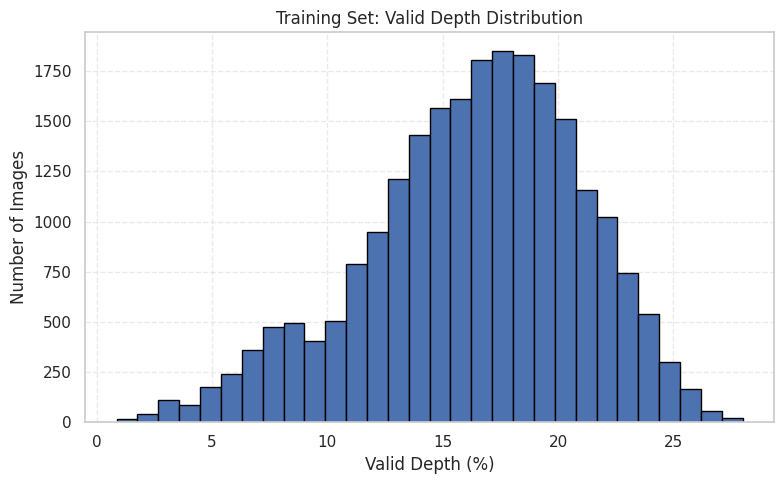

In [ ]:
plot_valid_depth_distribution(train_valid, "Training Set: Valid Depth Distribution")

### This shows there is less amount of valid depth maps in KITTI sparse dataset.

## View single and ground truth depth maps

Displaying sample 1
Depth range: min=0.00 m, max=82.93 m


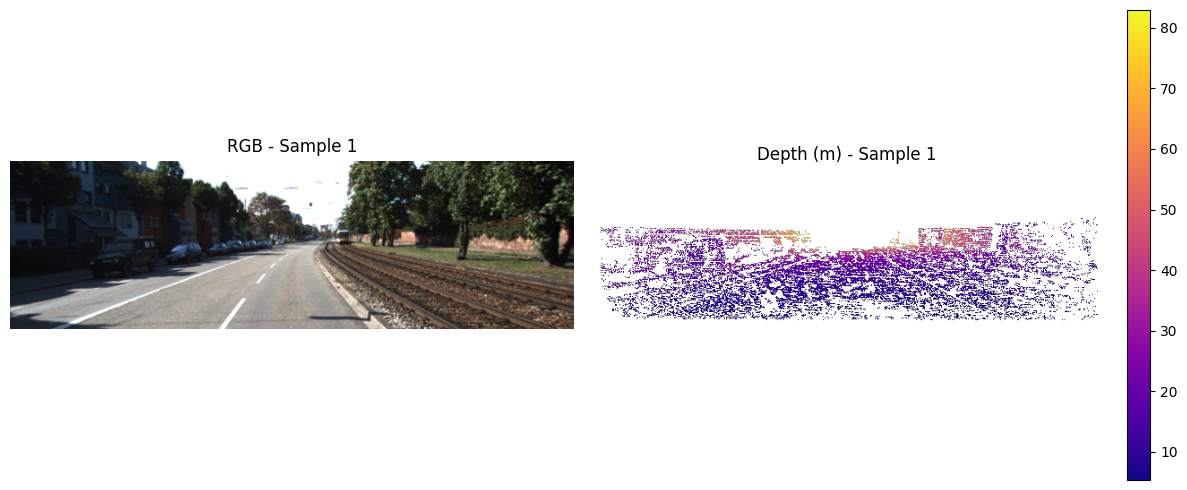

Displaying sample 2
Depth range: min=0.00 m, max=83.74 m


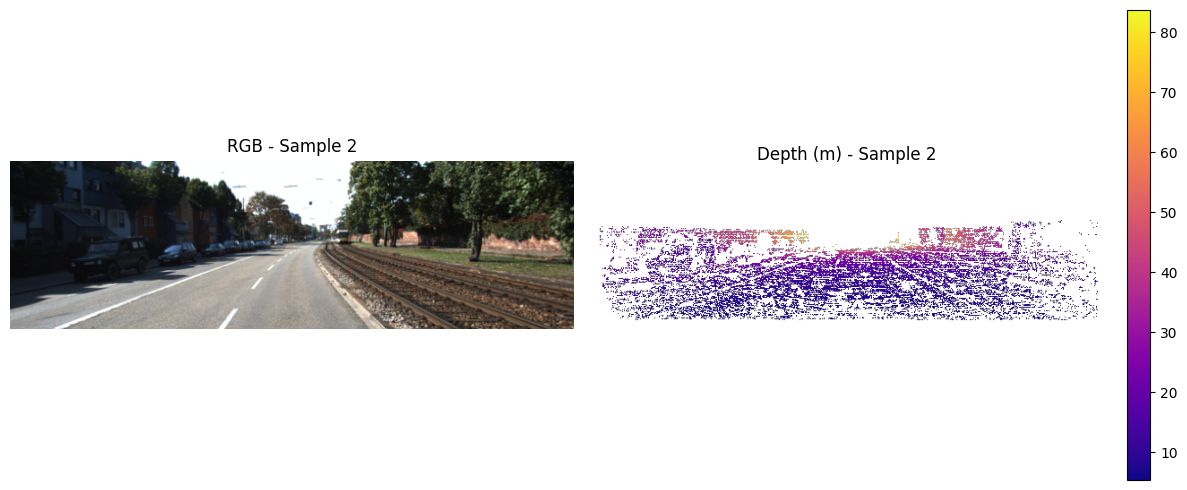

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_rgb_depth_sample(dataset, idx):
    # retrieve the (RGB, depth) pair at the given dataset index.
    rgb_t, depth_t = dataset[idx]

    # convert the normalized RGB tensor to a displayable numpy image

    # Rearrange from (C, H, W) to (H, W, C) for plotting
    rgb_np = rgb_t.permute(1, 2, 0).cpu().numpy()

    # ImageNet mean and standard deviation is used for de-normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Undo normalization: image = (image * std) + mean
    rgb_np = (rgb_np * std + mean).clip(0, 1)

    # Convert depth tensor to Numpy and mask invalid values

    # Remove channel Dimension -> (height, width)
    depth_np = depth_t.squeeze().cpu().numpy()

    # Create a masked array that hides invalid depth (<= 0)
    depth_masked = np.ma.masked_where(depth_np <= 0, depth_np)

    # Print min/max depth values to display
    print(f"Depth range: min={depth_np.min():.2f} m, max={depth_np.max():.2f} m")

    # Display the RGB image
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(rgb_np)
    axes[0].set_title(f"RGB - Sample {idx + 1}")
    axes[0].axis('off')

    # Display depth map with the color map
    im = axes[1].imshow(depth_masked, cmap='plasma')
    axes[1].set_title(f"Depth (m) - Sample {idx + 1}")
    axes[1].axis('off')

    # Add color bar next to depth map
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Show first few samples from the training dataset
for i in range(2):
    print(f"Displaying sample {i+1}")
    show_rgb_depth_sample(train_dataset, i)

### Setting Learning rates and number of epochs

In [12]:
import time, math
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize Eigen depth estimation model
model  = EigenDepthModel().to(device)

# training epochs for coarse and fine stages
epochs_coarse = 50
epochs_fine   = 30

# valid depth range in meters
min_depth, max_depth = 1e-3, 80.0  # (Max depth is set to 80 as most benchmarks and models are trained upto 80 meters)

# gradient clipping threshold (to prevent exploding gradients during training)
grad_clip = 1.0

# global and fine coarse maps
lr_coarse = 1e-3
lr_fine   = 1e-4

#### Downscale Groundtruth depth to fine output scale

In [13]:
def down4(x):
    # downscale Ground truth depth to fine output scale (1/4) for loss against fine
    return F.interpolate(x, scale_factor=0.25, mode='nearest')  # keep sparsity intact

In [14]:
CKPT_DIR = Path("/content/drive/MyDrive/kitti/EigenNetwork_2014/Checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

scaler = GradScaler(enabled=(device.type=='cuda'))

# Stage 1: Train Global Coarse Network

In [15]:
import torch
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")

Device: NVIDIA A100-SXM4-80GB
CUDA available: True
Current device: 0


### Loop to train the Coarse Network

In [ ]:
#  Loss history lists
train_losses = []   # list to store average training loss per epoch
val_losses = []     # list to store average validation loss per epoch


# Optimizer (SGD) for coarse network parameters
# In this stage it only updates the global coarse network
# Fine network stays frozen

optimizer = torch.optim.SGD([
    {'params': model.global_net.parameters(), 'lr': lr_coarse, 'momentum': 0.9}
], lr=lr_coarse, momentum=0.9)



# loop through coarse-stage training epochs
for epoch in range(1, epochs_coarse + 1):
    model.train()    # set model to training mode (enables dropout, Batch normalization updates)
    tr_loss = 0.0    # running training loss
    n_tr = 0         # count training batches
    t0 = time.time() # Timing for epoch duration

    # progress bar over training batches
    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Coarse {epoch:02d}/{epochs_coarse}", leave=True)

    for rgb, depth in pbar:
        # Move data to device
        rgb = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)

        # Resize groudtruth depth to match coarse output size
        # Coarse Network predicts low-resolution depth: (COARSE_DEPTH, COARSE_OUT_W)
        # takes the value of the nearest value of the closest pixel with no smoothing
        depth_coarse_gt = F.interpolate(depth,
                                        size=(COARSE_OUT_H,
                                        COARSE_OUT_W), mode='nearest')

        # Valid depth mask (KITTI sparse depth -> invalid pixels = 0)
        mask_coarse = (depth_coarse_gt > 0)


        # Reset gradients
        optimizer.zero_grad(set_to_none=True)

        # forward pass
        with autocast(enabled=(device.type == 'cuda')):
            coarse, _ = model(rgb)  # Only using coarse output

            # Clamp extreme values -> stabilize loss
            coarse = coarse.clamp(min=min_depth, max=max_depth)

            # Calculate the scale invariant error
            loss = silog_loss_masked(coarse, depth_coarse_gt, mask_coarse, lam=0.5)

        # backward + update
        scaler.scale(loss).backward()

        # gradiant clipping to prevent exploiding gradients
        if grad_clip:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        # Update running average loss for progress bar
        tr_loss += loss.item()
        n_tr += 1
        avg_loss = tr_loss / n_tr
        lr_cur = optimizer.param_groups[0]['lr']
        pbar.set_postfix(loss=f"{loss.item():.4f}", avg=f"{avg_loss:.4f}", lr=f"{lr_cur:.2e}")

    #  Validation Loop (No gradient Updates)
    model.eval()
    val_loss = 0.0
    n_val = 0

    with torch.no_grad():  # Disable gradient computation
        for rgb, depth in val_loader:
            rgb = rgb.to(device, non_blocking=True)
            depth = depth.to(device, non_blocking=True)

            # Resize Ground Truth to coarse resolution
            depth_coarse_gt = F.interpolate(
                depth, size=(COARSE_OUT_H, COARSE_OUT_W), mode='nearest')

            mask_coarse = (depth_coarse_gt > 0)

            # Same as training, but without grad
            with autocast(enabled=(device.type == 'cuda')):
                coarse, _ = model(rgb)
                coarse = coarse.clamp(min=min_depth, max=max_depth)
                loss = silog_loss_masked(coarse, depth_coarse_gt, mask_coarse, lam=0.5)

            val_loss += loss.item()
            n_val += 1

    val_avg = val_loss / max(n_val, 1)

    # store losses for plotting
    train_losses.append(tr_loss / max(n_tr, 1))
    val_losses.append(val_avg)

    # Epoch summary
    print(f"[Coarse {epoch:02d}/{epochs_coarse}] "
          f"train_loss={tr_loss/max(n_tr,1):.5f}  val_loss={val_avg:.5f}  "
          f"time={time.time()-t0:.1f}s")

# Save coarse-stage model checkpoint (used later when training the fine network)
torch.save({'stage': 'coarse', 'model': model.state_dict()},
           CKPT_DIR / 'coarse_only.pth')

Coarse 01/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.92it/s, avg=7.1834, loss=0.9694, lr=1.00e-03]


[Coarse 01/50] train_loss=7.18344  val_loss=0.63094  time=150.5s


Coarse 02/50: 100%|██████████| 1448/1448 [02:24<00:00, 10.00it/s, avg=0.5686, loss=0.2990, lr=1.00e-03]


[Coarse 02/50] train_loss=0.56864  val_loss=0.23539  time=149.0s


Coarse 03/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.92it/s, avg=0.2676, loss=0.2048, lr=1.00e-03]


[Coarse 03/50] train_loss=0.26764  val_loss=0.17883  time=150.2s


Coarse 04/50: 100%|██████████| 1448/1448 [02:24<00:00,  9.99it/s, avg=0.1991, loss=0.1491, lr=1.00e-03]


[Coarse 04/50] train_loss=0.19906  val_loss=0.15614  time=149.2s


Coarse 05/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.96it/s, avg=0.1728, loss=0.1507, lr=1.00e-03]


[Coarse 05/50] train_loss=0.17285  val_loss=0.14607  time=149.6s


Coarse 06/50: 100%|██████████| 1448/1448 [02:24<00:00, 10.00it/s, avg=0.1602, loss=0.1153, lr=1.00e-03]


[Coarse 06/50] train_loss=0.16020  val_loss=0.14083  time=149.2s


Coarse 07/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.99it/s, avg=0.1522, loss=0.1286, lr=1.00e-03]


[Coarse 07/50] train_loss=0.15222  val_loss=0.13682  time=149.2s


Coarse 08/50: 100%|██████████| 1448/1448 [02:24<00:00, 10.01it/s, avg=0.1460, loss=0.1069, lr=1.00e-03]


[Coarse 08/50] train_loss=0.14602  val_loss=0.13267  time=148.9s


Coarse 09/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.95it/s, avg=0.1417, loss=0.1421, lr=1.00e-03]


[Coarse 09/50] train_loss=0.14172  val_loss=0.13035  time=149.8s


Coarse 10/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.96it/s, avg=0.1382, loss=0.4885, lr=1.00e-03]


[Coarse 10/50] train_loss=0.13820  val_loss=0.12741  time=149.6s


Coarse 11/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.98it/s, avg=0.1347, loss=0.0963, lr=1.00e-03]


[Coarse 11/50] train_loss=0.13472  val_loss=0.12617  time=149.3s


Coarse 12/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.97it/s, avg=0.1323, loss=0.1621, lr=1.00e-03]


[Coarse 12/50] train_loss=0.13225  val_loss=0.12421  time=149.5s


Coarse 13/50: 100%|██████████| 1448/1448 [02:24<00:00,  9.99it/s, avg=0.1301, loss=0.1241, lr=1.00e-03]


[Coarse 13/50] train_loss=0.13011  val_loss=0.12354  time=149.1s


Coarse 14/50: 100%|██████████| 1448/1448 [02:24<00:00, 10.00it/s, avg=0.1281, loss=0.1230, lr=1.00e-03]


[Coarse 14/50] train_loss=0.12811  val_loss=0.12146  time=149.2s


Coarse 15/50: 100%|██████████| 1448/1448 [02:24<00:00, 10.01it/s, avg=0.1257, loss=0.1561, lr=1.00e-03]


[Coarse 15/50] train_loss=0.12575  val_loss=0.11981  time=148.9s


Coarse 16/50: 100%|██████████| 1448/1448 [02:24<00:00, 10.00it/s, avg=0.1243, loss=0.0757, lr=1.00e-03]


[Coarse 16/50] train_loss=0.12429  val_loss=0.11997  time=149.1s


Coarse 17/50: 100%|██████████| 1448/1448 [02:26<00:00,  9.89it/s, avg=0.1224, loss=0.1074, lr=1.00e-03]


[Coarse 17/50] train_loss=0.12245  val_loss=0.11924  time=150.7s


Coarse 18/50: 100%|██████████| 1448/1448 [02:26<00:00,  9.91it/s, avg=0.1210, loss=0.1164, lr=1.00e-03]


[Coarse 18/50] train_loss=0.12104  val_loss=0.11728  time=150.3s


Coarse 19/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.96it/s, avg=0.1192, loss=0.1211, lr=1.00e-03]


[Coarse 19/50] train_loss=0.11920  val_loss=0.11617  time=149.7s


Coarse 20/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.97it/s, avg=0.1176, loss=0.0944, lr=1.00e-03]


[Coarse 20/50] train_loss=0.11762  val_loss=0.11420  time=149.4s


Coarse 21/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.96it/s, avg=0.1161, loss=0.0962, lr=1.00e-03]


[Coarse 21/50] train_loss=0.11607  val_loss=0.11595  time=149.8s


Coarse 22/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.98it/s, avg=0.1144, loss=0.1146, lr=1.00e-03]


[Coarse 22/50] train_loss=0.11445  val_loss=0.11262  time=149.3s


Coarse 23/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.97it/s, avg=0.1134, loss=0.1037, lr=1.00e-03]


[Coarse 23/50] train_loss=0.11344  val_loss=0.11284  time=149.6s


Coarse 24/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.98it/s, avg=0.1119, loss=0.1087, lr=1.00e-03]


[Coarse 24/50] train_loss=0.11186  val_loss=0.11064  time=149.3s


Coarse 25/50: 100%|██████████| 1448/1448 [02:24<00:00,  9.99it/s, avg=0.1109, loss=0.0928, lr=1.00e-03]


[Coarse 25/50] train_loss=0.11089  val_loss=0.11064  time=149.1s


Coarse 26/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.98it/s, avg=0.1097, loss=0.1445, lr=1.00e-03]


[Coarse 26/50] train_loss=0.10970  val_loss=0.10872  time=149.5s


Coarse 27/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.93it/s, avg=0.1088, loss=0.1012, lr=1.00e-03]


[Coarse 27/50] train_loss=0.10881  val_loss=0.10959  time=150.0s


Coarse 28/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.97it/s, avg=0.1078, loss=0.1037, lr=1.00e-03]


[Coarse 28/50] train_loss=0.10776  val_loss=0.10807  time=149.5s


Coarse 29/50: 100%|██████████| 1448/1448 [02:24<00:00, 10.01it/s, avg=0.1067, loss=0.0915, lr=1.00e-03]


[Coarse 29/50] train_loss=0.10674  val_loss=0.10630  time=148.9s


Coarse 30/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.93it/s, avg=0.1060, loss=0.0940, lr=1.00e-03]


[Coarse 30/50] train_loss=0.10598  val_loss=0.10705  time=150.0s


Coarse 31/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.94it/s, avg=0.1051, loss=0.1389, lr=1.00e-03]


[Coarse 31/50] train_loss=0.10510  val_loss=0.10498  time=150.1s


Coarse 32/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.98it/s, avg=0.1044, loss=0.0947, lr=1.00e-03]


[Coarse 32/50] train_loss=0.10442  val_loss=0.10613  time=149.2s


Coarse 33/50: 100%|██████████| 1448/1448 [02:24<00:00, 10.00it/s, avg=0.1035, loss=0.0640, lr=1.00e-03]


[Coarse 33/50] train_loss=0.10352  val_loss=0.10425  time=149.2s


Coarse 34/50: 100%|██████████| 1448/1448 [02:24<00:00,  9.99it/s, avg=0.1029, loss=0.0723, lr=1.00e-03]


[Coarse 34/50] train_loss=0.10292  val_loss=0.10288  time=149.2s


Coarse 35/50: 100%|██████████| 1448/1448 [02:24<00:00,  9.99it/s, avg=0.1019, loss=0.0611, lr=1.00e-03]


[Coarse 35/50] train_loss=0.10188  val_loss=0.10392  time=149.1s


Coarse 36/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.95it/s, avg=0.1010, loss=0.0817, lr=1.00e-03]


[Coarse 36/50] train_loss=0.10098  val_loss=0.10187  time=150.0s


Coarse 37/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.95it/s, avg=0.1003, loss=0.0816, lr=1.00e-03]


[Coarse 37/50] train_loss=0.10027  val_loss=0.10194  time=149.7s


Coarse 38/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.96it/s, avg=0.0993, loss=0.0656, lr=1.00e-03]


[Coarse 38/50] train_loss=0.09927  val_loss=0.10014  time=149.8s


Coarse 39/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.96it/s, avg=0.0984, loss=0.1209, lr=1.00e-03]


[Coarse 39/50] train_loss=0.09843  val_loss=0.10049  time=149.7s


Coarse 40/50: 100%|██████████| 1448/1448 [02:26<00:00,  9.90it/s, avg=0.0976, loss=0.1135, lr=1.00e-03]


[Coarse 40/50] train_loss=0.09764  val_loss=0.09884  time=150.6s


Coarse 41/50: 100%|██████████| 1448/1448 [02:26<00:00,  9.89it/s, avg=0.0964, loss=0.1547, lr=1.00e-03]


[Coarse 41/50] train_loss=0.09643  val_loss=0.09989  time=150.6s


Coarse 42/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.96it/s, avg=0.0953, loss=0.1192, lr=1.00e-03]


[Coarse 42/50] train_loss=0.09535  val_loss=0.09809  time=149.7s


Coarse 43/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.97it/s, avg=0.0942, loss=0.1069, lr=1.00e-03]


[Coarse 43/50] train_loss=0.09423  val_loss=0.09685  time=149.6s


Coarse 44/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.97it/s, avg=0.0930, loss=0.1029, lr=1.00e-03]


[Coarse 44/50] train_loss=0.09300  val_loss=0.09561  time=149.5s


Coarse 45/50: 100%|██████████| 1448/1448 [02:25<00:00,  9.98it/s, avg=0.0920, loss=0.0780, lr=1.00e-03]


[Coarse 45/50] train_loss=0.09198  val_loss=0.09499  time=149.5s


Coarse 46/50: 100%|██████████| 1448/1448 [02:24<00:00,  9.99it/s, avg=0.0907, loss=0.0994, lr=1.00e-03]


[Coarse 46/50] train_loss=0.09070  val_loss=0.09354  time=149.1s


Coarse 47/50: 100%|██████████| 1448/1448 [02:24<00:00, 10.04it/s, avg=0.0897, loss=0.0693, lr=1.00e-03]


[Coarse 47/50] train_loss=0.08974  val_loss=0.09310  time=148.5s


Coarse 48/50: 100%|██████████| 1448/1448 [02:24<00:00,  9.99it/s, avg=0.0886, loss=0.0752, lr=1.00e-03]


[Coarse 48/50] train_loss=0.08863  val_loss=0.09184  time=149.1s


Coarse 49/50: 100%|██████████| 1448/1448 [02:24<00:00, 10.02it/s, avg=0.0876, loss=0.0797, lr=1.00e-03]


[Coarse 49/50] train_loss=0.08764  val_loss=0.09096  time=148.7s


Coarse 50/50: 100%|██████████| 1448/1448 [02:24<00:00, 10.00it/s, avg=0.0867, loss=0.0760, lr=1.00e-03]


[Coarse 50/50] train_loss=0.08673  val_loss=0.08996  time=149.2s


#### Loss Curves of the trained Coarse Network

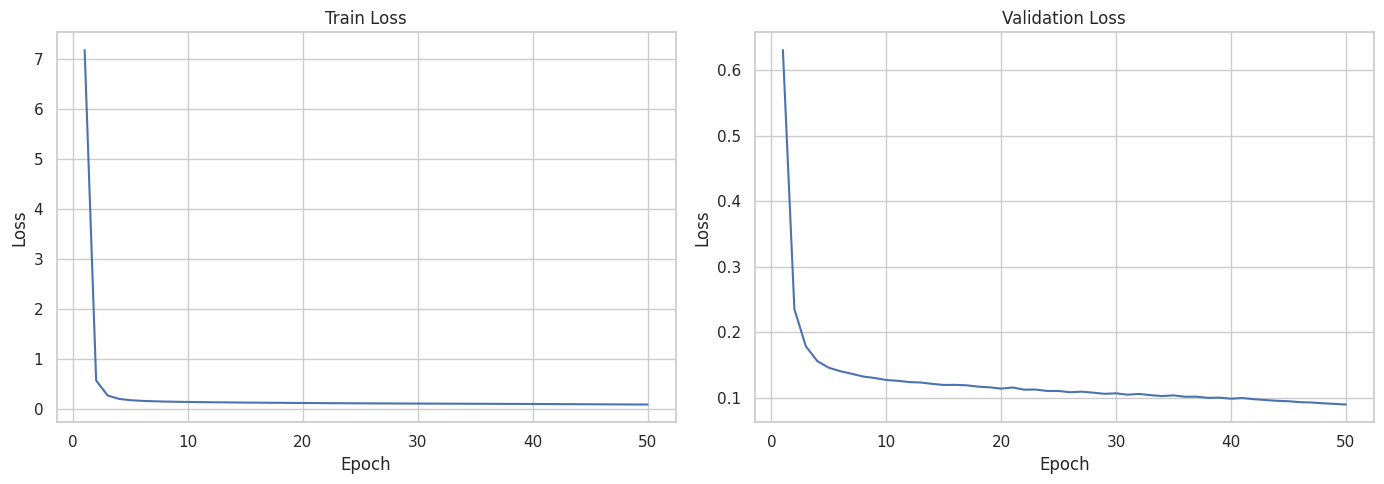

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# train Loss
sns.lineplot(
    x=range(1, len(train_losses)+1),
    y=train_losses,
    ax=axes[0]
)
axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# validation Loss
sns.lineplot(
    x=range(1, len(val_losses)+1),
    y=val_losses,
    ax=axes[1]
)
axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

#### Loss curves from the second epoch

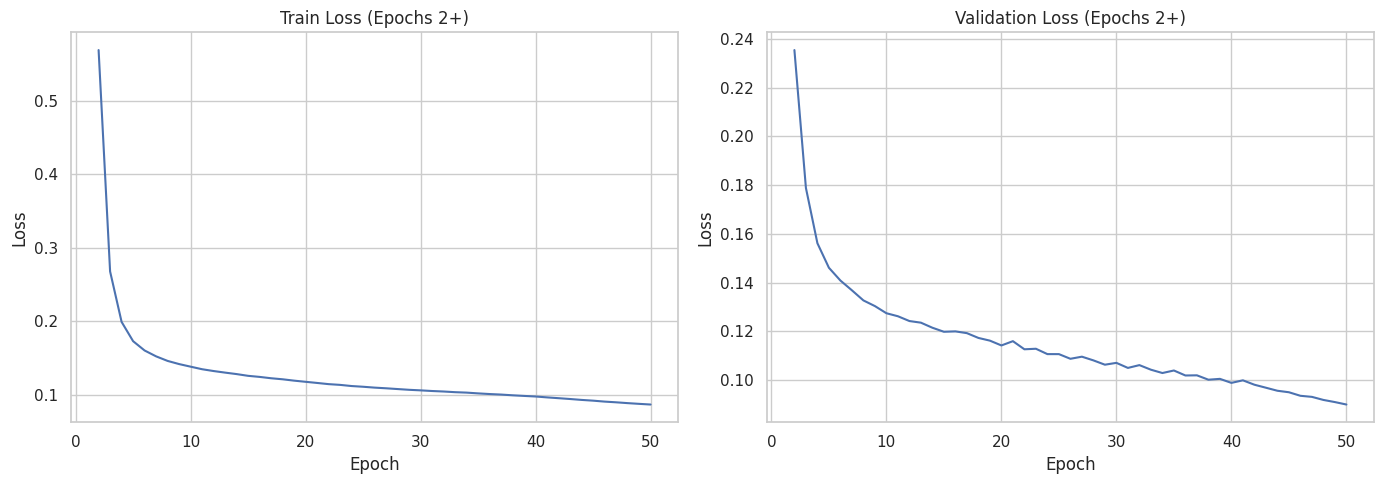

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Epoch indices starting from 2
train_epochs = list(range(2, len(train_losses) + 1))
val_epochs = list(range(2, len(val_losses) + 1))

# Train Loss
sns.lineplot(
    x=train_epochs,
    y=train_losses[1:],   # skip first element
    ax=axes[0]
)
axes[0].set_title("Train Loss (Epochs 2+)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Validation Loss
sns.lineplot(
    x=val_epochs,
    y=val_losses[1:],    # skip first element
    ax=axes[1]
)
axes[1].set_title("Validation Loss (Epochs 2+)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

# Inference test on the Coarse Model

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# select GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# directory where checkpoints are stored
CKPT_DIR = Path("/content/drive/MyDrive/kitti/EigenNetwork_2014/Checkpoints")

# load trained models
coarse_ckpt_path = CKPT_DIR / "coarse_only.pth"

# initialize two separate model instances
model_coarse = EigenDepthModel().to(device)

# load checkpoint data
coarse_state = torch.load(coarse_ckpt_path, map_location=device)

# restore weights into the model
model_coarse.load_state_dict(coarse_state['model'])

# switch to evaluation mode
model_coarse.eval()

print(f"Loaded Coarse Model: {coarse_ckpt_path}")

Loaded Coarse Model: /content/drive/MyDrive/kitti/EigenNetwork_2014/Checkpoints/coarse_only.pth


In [17]:
# pick one RGB-Depth pair from validation set
rgb_t, depth_t = val_dataset[100]

# prepare input batch
rgb_batch = rgb_t.unsqueeze(0).to(device)

# run inference (no gradient)
with torch.no_grad():
    coarse_pred_coarse, fine_pred_coarse = model_coarse(rgb_batch)

# convert model outputs to numpy arrays
coarse_pred_coarse = coarse_pred_coarse[0, 0].detach().cpu().numpy()

# de-normalize RGB for display
rgb_img = (rgb_t.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

#### Output of the Coarse Network

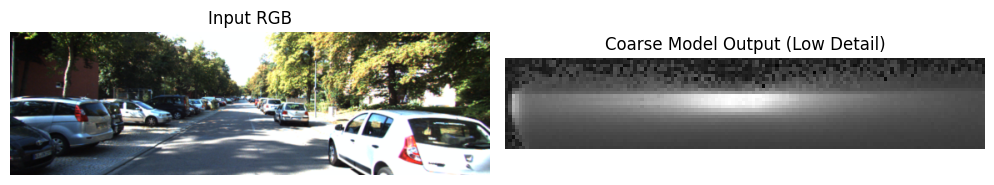

In [18]:
plt.figure(figsize=(15, 5))

# input RGB (Grayscale)
plt.subplot(1, 3, 1)
plt.title("Input RGB")
plt.imshow(rgb_img)
plt.axis('off')

# coarse Model (Fine Output)
plt.subplot(1, 3, 2)
plt.title("Coarse Model Output (Low Detail)")
plt.imshow(coarse_pred_coarse, cmap='gray')
plt.axis('off')


plt.tight_layout()
plt.show()

# Stage 2: Train the Fine Network

In [ ]:
# Load coarse weights and fine-tune with iterative joint training
ckpt_path = CKPT_DIR / 'coarse_only.pth'
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model'])
print(f"Loaded coarse weights from: {ckpt_path}")

freeze_epochs = 5  # number of epochs to train fine network alone

# freeze all parameters of the coarse network at the beginning
for p in model.global_net.parameters():
    p.requires_grad_(False)

#  optimizer: updates fine network normally and coarse network very slowly
optimizer = torch.optim.SGD([
    {'params': model.local_net.parameters(), 'lr': lr_fine, 'momentum': 0.9},       # fine net
    {'params': model.global_net.parameters(), 'lr': lr_fine * 0.2, 'momentum': 0.9} # coarse net
], lr=lr_fine, momentum=0.9)

# initialize mixed-precision scaler
scaler = torch.cuda.amp.GradScaler()

# list to store training and validation losses
train_losses = []
val_losses = []

# start fine + joint training loop
for epoch in range(1, epochs_fine + 1):

    # unfreeze coarse network after a few epochs for joint training
    if epoch == freeze_epochs + 1:
        print(f"\n[Info] Unfreezing coarse network for joint fine-tuning after {freeze_epochs} epochs...\n")
        for p in model.global_net.parameters():
            p.requires_grad_(True)

    # set model to training mode
    model.train()    # enable training mode
    tr_loss = 0.0    # running training loss
    n_tr = 0         # number of training batches
    t0 = time.time() # track epoch time

    # progress bar for training batches
    pbar = tqdm(train_loader, total=len(train_loader),
                desc=f"Fine {epoch:02d}/{epochs_fine}", leave=True)

    for rgb, depth in pbar:
        # move batch to device
        rgb = rgb.to(device, non_blocking=True)
        depth = depth.to(device, non_blocking=True)

        # prepare fine resolution and coarse-resolution groundtruth depth
        depth_fine_gt = down4(depth)
        depth_coarse_gt = F.interpolate(depth, size=(COARSE_OUT_H, COARSE_OUT_W), mode='nearest')

        # masks identify valid sparse depths
        mask_fine = (depth_fine_gt > 0) # valid fine-depth pixels
        mask_coarse = (depth_coarse_gt > 0)  # valid coarse-depth pixels

        optimizer.zero_grad(set_to_none=True)

        # foward pass through batch network
        with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
            coarse, fine = model(rgb)

            # clamp predictions to avoid very large depth errors
            fine = fine.clamp(min=min_depth, max=max_depth)
            coarse = coarse.clamp(min=min_depth, max=max_depth)

            # compute loss for fine and coarse
            loss_fine = silog_loss_masked(fine, depth_fine_gt, mask_fine, lam=0.5)
            loss_coarse = silog_loss_masked(coarse, depth_coarse_gt, mask_coarse, lam=0.5) * 0.1
            loss = loss_fine + loss_coarse

        # backpropagation with gradient clipping
        scaler.scale(loss).backward()
        if grad_clip:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        tr_loss += loss.item()
        n_tr += 1
        pbar.set_postfix({'loss': f'{tr_loss / max(n_tr, 1):.5f}'})

    # average loss for plotting
    avg_train_loss = tr_loss / max(n_tr, 1)
    train_losses.append(avg_train_loss)

    print(f"[Fine {epoch:02d}/{epochs_fine}] loss={avg_train_loss:.5f} "
          f"time={time.time()-t0:.1f}s")

    # Validation step (no gradient updates)
    model.eval()
    val_loss = 0.0
    n_val = 0

    with torch.no_grad():
        for rgb, depth in val_loader:
            rgb = rgb.to(device, non_blocking=True)
            depth = depth.to(device, non_blocking=True)

            # Downsample ground truth
            depth_fine_gt = down4(depth)
            depth_coarse_gt = F.interpolate(depth, size=(COARSE_OUT_H, COARSE_OUT_W), mode='nearest')

            mask_fine = (depth_fine_gt > 0)
            mask_coarse = (depth_coarse_gt > 0)

            with torch.cuda.amp.autocast(enabled=(device.type == 'cuda')):
                coarse, fine = model(rgb)

                fine = fine.clamp(min=min_depth, max=max_depth)
                coarse = coarse.clamp(min=min_depth, max=max_depth)

                # same loss used for validation
                loss_fine = silog_loss_masked(fine, depth_fine_gt, mask_fine, lam=0.5)
                loss_coarse = silog_loss_masked(coarse, depth_coarse_gt, mask_coarse, lam=0.5) * 0.1
                loss = loss_fine + loss_coarse

            val_loss += loss.item()
            n_val += 1

    avg_val_loss = val_loss / max(n_val, 1)
    val_losses.append(avg_val_loss)

    print(f"[VAL {epoch:02d}] val_loss={avg_val_loss:.5f}")

# Save final trained model
torch.save({'stage': 'fine_joint', 'model': model.state_dict()},
           CKPT_DIR / 'coarse_joint_fine_trained.pth')

Loaded coarse weights from: /content/drive/MyDrive/kitti/EigenNetwork_2014/Checkpoints/coarse_only.pth


Fine 01/30: 100%|██████████| 1448/1448 [02:26<00:00,  9.85it/s, loss=0.79028]


[Fine 01/30] loss=0.79028 time=146.9s
[VAL 01] val_loss=0.09366


Fine 02/30: 100%|██████████| 1448/1448 [02:26<00:00,  9.86it/s, loss=0.08585]


[Fine 02/30] loss=0.08585 time=146.8s
[VAL 02] val_loss=0.08892


Fine 03/30: 100%|██████████| 1448/1448 [02:26<00:00,  9.87it/s, loss=0.08182]


[Fine 03/30] loss=0.08182 time=146.7s
[VAL 03] val_loss=0.08545


Fine 04/30: 100%|██████████| 1448/1448 [02:26<00:00,  9.89it/s, loss=0.07892]


[Fine 04/30] loss=0.07892 time=146.5s
[VAL 04] val_loss=0.08303


Fine 05/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.84it/s, loss=0.07729]


[Fine 05/30] loss=0.07729 time=147.2s
[VAL 05] val_loss=0.08155

[Info] Unfreezing coarse network for joint fine-tuning after 5 epochs...



Fine 06/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.78it/s, loss=0.07528]


[Fine 06/30] loss=0.07528 time=148.1s
[VAL 06] val_loss=0.07932


Fine 07/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.78it/s, loss=0.07426]


[Fine 07/30] loss=0.07426 time=148.0s
[VAL 07] val_loss=0.07893


Fine 08/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.76it/s, loss=0.07387]


[Fine 08/30] loss=0.07387 time=148.4s
[VAL 08] val_loss=0.07859


Fine 09/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.74it/s, loss=0.07322]


[Fine 09/30] loss=0.07322 time=148.7s
[VAL 09] val_loss=0.07827


Fine 10/30: 100%|██████████| 1448/1448 [02:29<00:00,  9.66it/s, loss=0.07296]


[Fine 10/30] loss=0.07296 time=150.0s
[VAL 10] val_loss=0.07822


Fine 11/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.72it/s, loss=0.07295]


[Fine 11/30] loss=0.07295 time=149.0s
[VAL 11] val_loss=0.07824


Fine 12/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.77it/s, loss=0.07256]


[Fine 12/30] loss=0.07256 time=148.2s
[VAL 12] val_loss=0.07802


Fine 13/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.76it/s, loss=0.07239]


[Fine 13/30] loss=0.07239 time=148.4s
[VAL 13] val_loss=0.07780


Fine 14/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.75it/s, loss=0.07225]


[Fine 14/30] loss=0.07225 time=148.4s
[VAL 14] val_loss=0.07773


Fine 15/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.77it/s, loss=0.07205]


[Fine 15/30] loss=0.07205 time=148.2s
[VAL 15] val_loss=0.07750


Fine 16/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.75it/s, loss=0.07186]


[Fine 16/30] loss=0.07186 time=148.5s
[VAL 16] val_loss=0.07752


Fine 17/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.75it/s, loss=0.07182]


[Fine 17/30] loss=0.07182 time=148.5s
[VAL 17] val_loss=0.07752


Fine 18/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.81it/s, loss=0.07157]


[Fine 18/30] loss=0.07157 time=147.6s
[VAL 18] val_loss=0.07739


Fine 19/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.80it/s, loss=0.07166]


[Fine 19/30] loss=0.07166 time=147.7s
[VAL 19] val_loss=0.07721


Fine 20/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.82it/s, loss=0.07151]


[Fine 20/30] loss=0.07151 time=147.5s
[VAL 20] val_loss=0.07703


Fine 21/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.81it/s, loss=0.07143]


[Fine 21/30] loss=0.07143 time=147.6s
[VAL 21] val_loss=0.07699


Fine 22/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.80it/s, loss=0.07125]


[Fine 22/30] loss=0.07125 time=147.8s
[VAL 22] val_loss=0.07722


Fine 23/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.78it/s, loss=0.07128]


[Fine 23/30] loss=0.07128 time=148.1s
[VAL 23] val_loss=0.07717


Fine 24/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.81it/s, loss=0.07114]


[Fine 24/30] loss=0.07114 time=147.6s
[VAL 24] val_loss=0.07704


Fine 25/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.82it/s, loss=0.07108]


[Fine 25/30] loss=0.07108 time=147.5s
[VAL 25] val_loss=0.07676


Fine 26/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.82it/s, loss=0.07088]


[Fine 26/30] loss=0.07088 time=147.4s
[VAL 26] val_loss=0.07676


Fine 27/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.81it/s, loss=0.07082]


[Fine 27/30] loss=0.07082 time=147.6s
[VAL 27] val_loss=0.07689


Fine 28/30: 100%|██████████| 1448/1448 [02:28<00:00,  9.78it/s, loss=0.07072]


[Fine 28/30] loss=0.07072 time=148.1s
[VAL 28] val_loss=0.07667


Fine 29/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.81it/s, loss=0.07075]


[Fine 29/30] loss=0.07075 time=147.7s
[VAL 29] val_loss=0.07655


Fine 30/30: 100%|██████████| 1448/1448 [02:27<00:00,  9.80it/s, loss=0.07059]


[Fine 30/30] loss=0.07059 time=147.8s
[VAL 30] val_loss=0.07645


#### Loss Curve of the Local Fine Network

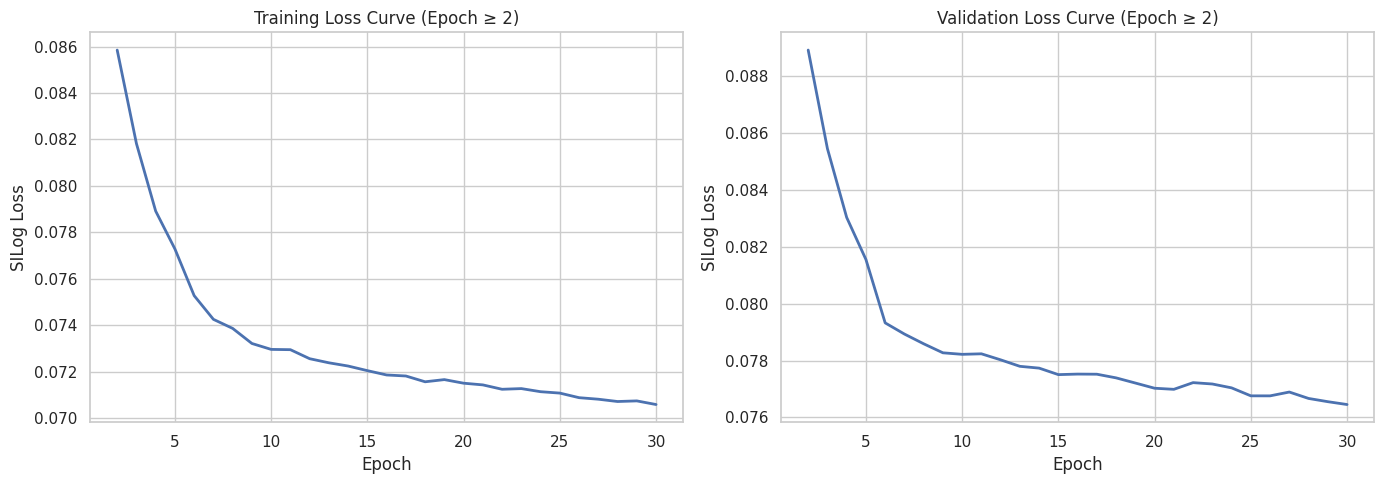

In [ ]:
import matplotlib.pyplot as plt

#  Slice to exclude epoch 1
train_plot = train_losses[1:]
val_plot = val_losses[1:]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Training Loss (from epoch 2)
axes[0].plot(range(2, 2 + len(train_plot)), train_plot, linewidth=2)
axes[0].set_title("Training Loss Curve (Epoch ≥ 2)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("SILog Loss")
axes[0].grid(True)

# Right: Validation Loss (from epoch 2)
axes[1].plot(range(2, 2 + len(val_plot)), val_plot, linewidth=2)
axes[1].set_title("Validation Loss Curve (Epoch ≥ 2)")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("SILog Loss")
axes[1].grid(True)

plt.tight_layout()
plt.show()

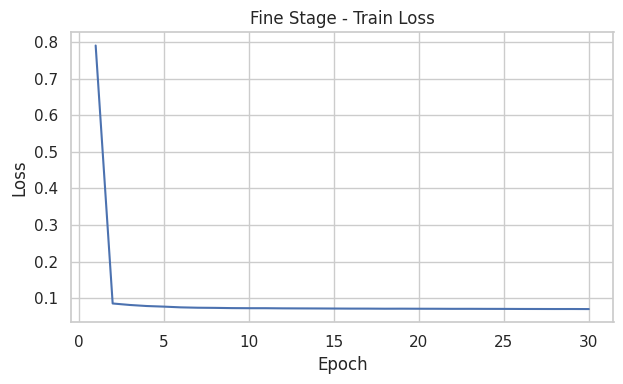

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# Train loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses)
plt.title("Fine Stage - Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)


plt.tight_layout()
plt.show()

# Model Inference

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ensure you have the same device used during training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define checkpoint directory
CKPT_DIR = Path("/content/drive/MyDrive/kitti/EigenNetwork_2014/Checkpoints")

# load trained models
coarse_ckpt_path = CKPT_DIR / "coarse_only.pth"
fine_ckpt_path   = CKPT_DIR / "coarse_joint_fine_trained.pth"

# initialize two separate model instances
model_coarse = EigenDepthModel().to(device)
model_fine   = EigenDepthModel().to(device)

# load checkpoint states
coarse_state = torch.load(coarse_ckpt_path, map_location=device)
fine_state   = torch.load(fine_ckpt_path, map_location=device)

model_coarse.load_state_dict(coarse_state['model'])
model_fine.load_state_dict(fine_state['model'])

model_coarse.eval()
model_fine.eval()

print(f"Loaded Coarse Model: {coarse_ckpt_path}")
print(f"Loaded Fine-Tuned Model: {fine_ckpt_path}")

Loaded Coarse Model: /content/drive/MyDrive/kitti/EigenNetwork_2014/Checkpoints/coarse_only.pth
Loaded Fine-Tuned Model: /content/drive/MyDrive/kitti/EigenNetwork_2014/Checkpoints/coarse_joint_fine_trained.pth


In [21]:
# pick one RGB-Depth pair from validation set
rgb_t, depth_t = val_dataset[100]

# prepare input batch
rgb_batch = rgb_t.unsqueeze(0).to(device)

# run inference (no gradient)
with torch.no_grad():
    coarse_pred_coarse, fine_pred_coarse = model_coarse(rgb_batch)
    coarse_pred_fine, fine_pred_fine     = model_fine(rgb_batch)

# convert model outputs to numpy arrays
coarse_pred_coarse = coarse_pred_coarse[0, 0].detach().cpu().numpy()
fine_pred_coarse   = fine_pred_coarse[0, 0].detach().cpu().numpy()
coarse_pred_fine   = coarse_pred_fine[0, 0].detach().cpu().numpy()
fine_pred_fine     = fine_pred_fine[0, 0].detach().cpu().numpy()

# de-normalize RGB for display
rgb_img = (rgb_t.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

## Coarse Model Architecture

In [ ]:
print("\n=== Fine-Tuned Model Architecture ===")
print(model_fine)


=== Fine-Tuned Model Architecture ===
EigenDepthModel(
  (global_net): GlobalCoarseNet(
    (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(5, 5))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (adapt): AdaptiveAvgPool2d(output_size=(4, 17))
    (fc1): Linear(in_features=17408, out_features=4096, bias=True)
    (drop): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=4096, out_features=3834, bias=True)
  )
  (local_net)

## Original Image and Coarse Model Output

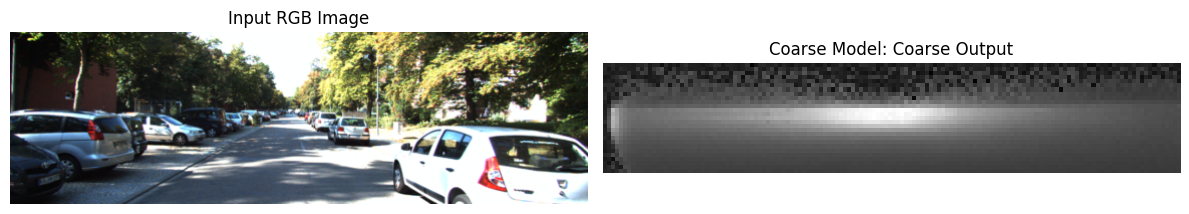

In [22]:
plt.figure(figsize=(12, 4))

# plot the original rgb image
plt.subplot(1, 2, 1)
plt.title("Input RGB Image")
plt.imshow(rgb_img)
plt.axis('off')

# plot the coarse model output
plt.subplot(1, 2, 2)
plt.title("Coarse Model: Coarse Output")
plt.imshow(coarse_pred_coarse, cmap='gray')
plt.axis('off')

plt.tight_layout()

# render the final figure
plt.show()

## Original Image and Fine Network Finalized Output

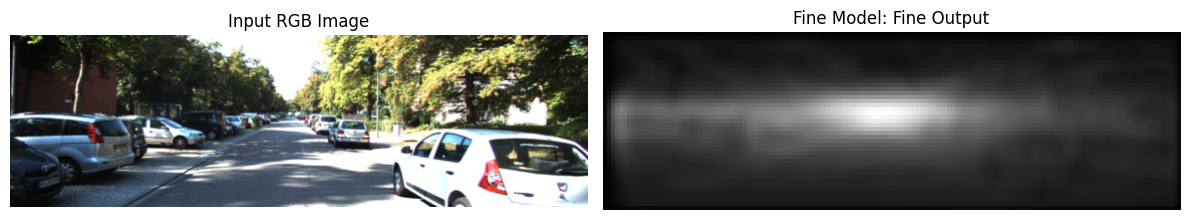

In [23]:
plt.figure(figsize=(12, 4))

# plot the original rgb input image
plt.subplot(1, 2, 1)
plt.title("Input RGB Image")
plt.imshow(rgb_img)
plt.axis('off')

# plot the fine model output depth map
plt.subplot(1, 2, 2)
plt.title("Fine Model: Fine Output")
plt.imshow(fine_pred_fine, cmap='gray')
plt.axis('off')

plt.tight_layout()

# render the final figure
plt.show()

### Some Other samples

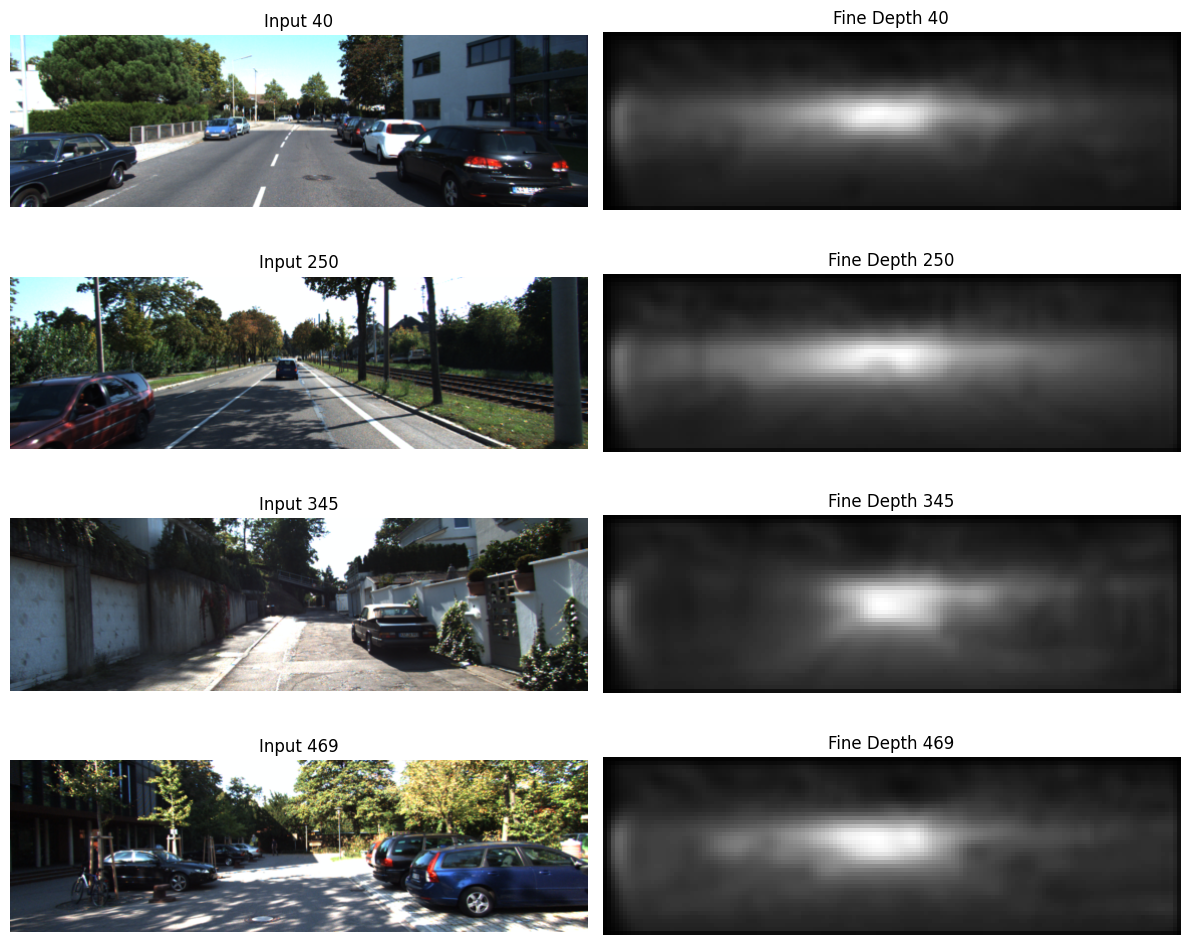

In [24]:
indices = [40, 250, 345, 469]

plt.figure(figsize=(12, 10))

for i, idx in enumerate(indices):
    # get the rgb tensor and ignore the depth target
    rgb_t, _ = val_dataset[idx]

    # convert the tensor back to an image by reversing normalization
    rgb_img = (rgb_t.permute(1,2,0).numpy() * [0.229,0.224,0.225] +
               [0.485,0.456,0.406]).clip(0,1)

    # add batch dimension and move to device for inference
    rgb_batch = rgb_t.unsqueeze(0).to(device)

     # run the fine model without tracking gradients
    with torch.no_grad():
        _, fine_pred_fine = model_fine(rgb_batch)

     # extract the predicted depth map and move to cpu
    fine_pred_fine = fine_pred_fine[0,0].cpu().numpy()

    # show the input image
    plt.subplot(len(indices), 2, 2*i+1)
    plt.imshow(rgb_img)
    plt.title(f"Input {idx}")
    plt.axis('off')

    # show the depth prediction
    plt.subplot(len(indices), 2, 2*i+2)
    plt.imshow(fine_pred_fine, cmap='gray')
    plt.title(f"Fine Depth {idx}")
    plt.axis('off')

plt.tight_layout()

# display all results
plt.show()

### Original work image

#### Image on top shows original image, next coarse output, then fine network output, then original grountruth

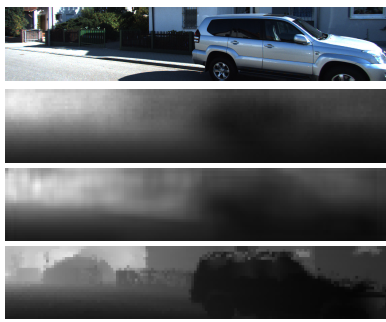

# Evaluation Results

In [ ]:
def compute_metrics(pred, gt, min_depth=1e-3, max_depth=80.0):
    """
    Compute all standard KITTI Eigen metrics:
      - AbsRel, SqRel
      - RMSE, RMSE_log
      - SIlog (scale-invariant)
      - delta1, delta2, delta3 accuracy thresholds
    """
    # Convert to float arrays
    gt = np.asarray(gt, np.float32)
    pred = np.asarray(pred, np.float32)

    # use only valid depths (KITTI has holes, invalid values, sky areas)
    valid = np.isfinite(gt) & (gt > min_depth) & (gt < max_depth)
    if valid.sum() == 0:
        return [np.nan] * 8

    # apply valid-mask
    gt   = gt[valid]
    pred = np.clip(pred[valid], min_depth, max_depth)

    # absolute Relative Error
    abs_rel = np.mean(np.abs(gt - pred) / gt)

    # squared Relative Error
    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    # RMSE (linear)
    rmse = np.sqrt(np.mean((gt - pred) ** 2))

    # RMSE in log space
    rmse_log = np.sqrt(np.mean((np.log(gt) - np.log(pred)) ** 2))

    # Scale-Invariant log RMSE (from Eigen et al.)
    d = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(d**2) - (np.mean(d)**2))

    # Accuracy thresholds (delta metrics)
    ratio = np.maximum(gt / pred, pred / gt)
    delta1 = np.mean(ratio < 1.25)
    delta2 = np.mean(ratio < 1.25**2)
    delta3 = np.mean(ratio < 1.25**3)

    return abs_rel, sq_rel, rmse, rmse_log, silog, delta1, delta2, delta3

#### Function to run the evaluation Loop

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def evaluate_kitti(model, dataloader, device, use_fine=False, desc="Eval"):
    """
    Evaluate a model on KITTI-style data.

    - If use_fine=False: use coarse prediction.
    - If use_fine=True:  use fine prediction.
    """
    model.eval()
    all_metrics = []

    with torch.no_grad():
        for rgb, depth in tqdm(dataloader, desc=desc):
            rgb   = rgb.to(device, non_blocking=True)
            depth = depth.to(device, non_blocking=True)

            # forward pass: EigenDepthModel returns (coarse, fine)
            out = model(rgb)
            if isinstance(out, (tuple, list)):
                coarse_pred, fine_pred = out
                pred = fine_pred if use_fine else coarse_pred
            else:
                # if model only returns one output, treat as coarse
                pred = out

            # clamp and upsample to GT resolution
            pred = pred.clamp(1e-3, 80.0)
            pred_up = F.interpolate(
                pred, size=depth.shape[2:], mode="bilinear", align_corners=False
            )

            # per-image metrics
            for b in range(rgb.size(0)):
                p = pred_up[b, 0].cpu().numpy()
                g = depth[b, 0].cpu().numpy()
                all_metrics.append(compute_metrics(p, g))

    metrics_arr = np.array(all_metrics, np.float32)
    metrics_arr = metrics_arr[~np.isnan(metrics_arr).any(axis=1)]
    means = np.nanmean(metrics_arr, axis=0)

    names = ["AbsRel","SqRel","RMSE","RMSE_log","SIlog","Delta1","Delta2","Delta3"]

    print(f"\n--- {desc} ---")
    for n, v in zip(names, means):
        print(f"{n:12s}: {v:.4f}")

    return dict(zip(names, means))

In [ ]:
from torch.utils.data import DataLoader

eval_loader = DataLoader(val_dataset, batch_size=4, num_workers=0, shuffle=False)

# 1) Coarse column in Table 2 → coarse-only model, coarse output
metrics_coarse = evaluate_kitti(
    model_coarse, eval_loader, device,
    use_fine=False,
    desc="KITTI Coarse-only Model (Coarse output)"
)

# 2) Coarse + Fine column in Table 2 → fine-tuned model, FINAL fine output
metrics_coarse_fine = evaluate_kitti(
    model_fine, eval_loader, device,
    use_fine=True,
    desc="KITTI Coarse+Fine Model (Fine output)"
)

KITTI Coarse-only Model (Coarse output): 100%|██████████| 163/163 [17:24<00:00,  6.41s/it]



--- KITTI Coarse-only Model (Coarse output) ---
AbsRel      : 0.1982
SqRel       : 1.5628
RMSE        : 6.8461
RMSE_log    : 0.2842
SIlog       : 0.2554
Delta1      : 0.6813
Delta2      : 0.8789
Delta3      : 0.9563


KITTI Coarse+Fine Model (Fine output): 100%|██████████| 163/163 [00:19<00:00,  8.26it/s]


--- KITTI Coarse+Fine Model (Fine output) ---
AbsRel      : 0.1880
SqRel       : 1.3195
RMSE        : 5.9134
RMSE_log    : 0.2480
SIlog       : 0.2248
Delta1      : 0.7308
Delta2      : 0.9099
Delta3      : 0.9703


## Evaluation Results on KITTI dataset

- δ < 1.25
percentage of predicted depth values that are within a factor of 1.25 of the ground truth.
higher is better.

- δ < 1.25²
percentage of predicted depth values that are within a factor of 1.25² (1.5625) of the ground truth.
higher is better.

- δ < 1.25³
percentage of predicted depth values that are within a factor of 1.25³ (1.9531) of the ground truth.
higher is better.

- Abs Rel (Absolute Relative Error)
measures how far predictions deviate from ground truth in relative terms:
lower is better.

- Sq Rel (Squared Relative Error)
penalizes large depth errors more heavily using squared differences.
lower is better.

- RMSE (Root Mean Squared Error)
measures the overall magnitude of prediction errors.
lower is better.

- RMSE log
computes RMSE in log space to reduce the influence of large depth values.
lower is better.

- SIlog (Scale-Invariant Log RMSE)
evaluates depth in a scale-invariant way, ignoring uniform scaling errors.
useful for monocular depth.

#### This evaluation is done using 625 images of the testing dataset.

In [ ]:
import pandas as pd

# Build a dictionary where each key is a metric (row)
# and each value is another dict of model → value
table = {
    "δ < 1.25": {
        "Coarse": metrics_coarse["Delta1"],
        "Coarse + Fine": metrics_coarse_fine["Delta1"],
    },
    "δ < 1.25²": {
        "Coarse": metrics_coarse["Delta2"],
        "Coarse + Fine": metrics_coarse_fine["Delta2"],
    },
    "δ < 1.25³": {
        "Coarse": metrics_coarse["Delta3"],
        "Coarse + Fine": metrics_coarse_fine["Delta3"],
    },
    "Abs Rel": {
        "Coarse": metrics_coarse["AbsRel"],
        "Coarse + Fine": metrics_coarse_fine["AbsRel"],
    },
    "Sq Rel": {
        "Coarse": metrics_coarse["SqRel"],
        "Coarse + Fine": metrics_coarse_fine["SqRel"],
    },
    "RMSE": {
        "Coarse": metrics_coarse["RMSE"],
        "Coarse + Fine": metrics_coarse_fine["RMSE"],
    },
    "RMSE log": {
        "Coarse": metrics_coarse["RMSE_log"],
        "Coarse + Fine": metrics_coarse_fine["RMSE_log"],
    },
    "RMSE (log, scale inv.)": {
        "Coarse": metrics_coarse["SIlog"],
        "Coarse + Fine": metrics_coarse_fine["SIlog"],
    }
}

# Build DataFrame
df_kitti = pd.DataFrame(table).T  # transpose → metrics as rows

# Round for neatness
df_kitti = df_kitti.round(4)

df_kitti

,Coarse,Coarse + Fine
δ < 1.25,0.6813,0.7308
δ < 1.25²,0.8789,0.9099
δ < 1.25³,0.9563,0.9703
Abs Rel,0.1982,0.1880
Sq Rel,1.5628,1.3195
RMSE,6.8461,5.9134
RMSE log,0.2842,0.2480
"RMSE (log, scale inv.)",0.2554,0.2248


### Original Paper Obtained Results on KITTI dataset (This benchmark is done using 700 images)

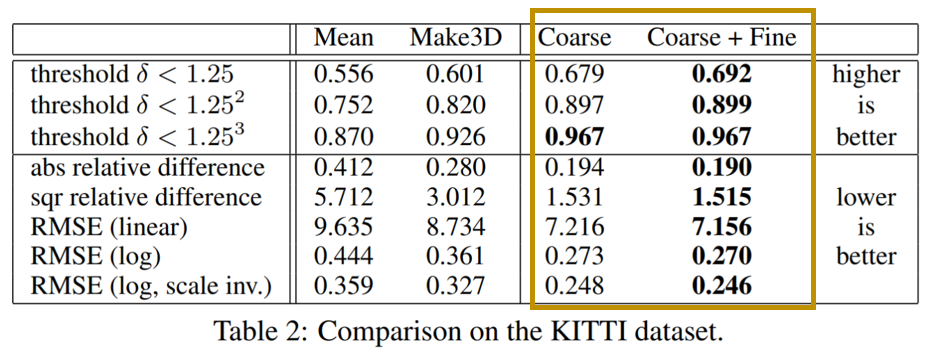

## Limitations of this work compared to original work

- Worked with the Eigen split of the dataset due to its size (the original paper was trained on the full dataset, which contains 28×800 training images and 28×800 testing images, and was further augmented for training).

- In the original network, they have trained the coarse network with 1.5M samples and fine with 1M samples, but here we have taken only 23k samples to train both

- Since the original paper does not mention the number of epochs used to train the model on KITTI dataset, the coarse network was trained for 50 epochs and the fine network for 30 epochs.

- The paper does not clearly describe the data augmentation process for the KITTI dataset, even though augmentation is discussed for the NYU dataset. Because the KITTI split already contains around 23k images and GPU limitations make additional augmentation difficult, no extra data augmentation was applied.